In [1]:
import os
import re
from typing import Callable, Union
from string import punctuation
from collections import namedtuple
import copy
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
ROOT_DIR = os.path.split(os.getcwd())[0]


df = pd.read_csv(
    os.path.join(ROOT_DIR, 'data', 'processed', 'dataset.csv'),
    quotechar='"',
    encoding='utf-8'
)
df.head()

,journal,DOI,abstract,keywords
0,ieee-proc,10.1109/PROC.1966.4567,The present report calculates in some detail t...,0000100000000000000000000000000000000000000000...
1,ieee-proc,10.1109/PROC.1966.4569,"In this paper, a novel method of evaluating tr...",0000100001000000000000000001000010000000000000...
2,ieee-proc,10.1109/PROC.1966.4570,Characteristics of a sealed vacuum gap are des...,0000000000000000000000000000000000000000000000...
3,ieee-proc,10.1109/PROC.1966.4571,Conventional matched filters which use pseudor...,0000100000100000000000000000000000000000000000...
4,ieee-proc,10.1109/PROC.1966.4572,A reading device for the blind is proposed in ...,0000000000000000000000000000000000000000100000...


In [3]:
for _, row in df.iterrows():
    s = row['abstract']
    s = s.lower()                              # make lowercase
    s = re.sub(r'\\[\S]+', '', s)              # remove all backslash sequences
    s = re.sub(r'\[[0-9]+\]', '', s)           # remove citations
    s = re.sub(r'[0-9]+(?:\.[0-9]+)?', '', s)  # remove numbers
    for ch in punctuation:
        s = s.replace(ch, '')
    s = s.encode(encoding='ascii', errors='ignore').decode()
    s = re.sub(r'\s+', ' ', s)       # remove tabs and multiple spaces
    row['abstract'] = s

df.sample()['abstract']

13160    we propose a new technique for stability analy...
Name: abstract, dtype: object

In [4]:
Y = np.array([list(map(int, mask)) for mask in df['keywords']])
Y

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [5]:
n = 5

mask = Y[:, :n].any(axis=1)
print(f'{n} top keywords: {np.sum(mask)} abstracts')
top5 = df[mask].copy()
for _, row in top5.iterrows():
    row['keywords'] = row['keywords'][:n]

top5.sample(5)

5 top keywords: 18929 abstracts


,journal,DOI,abstract,keywords
52175,ieee-tcom,10.1109/TCOM.1983.1095821,in this paper the performance of a direct sequ...,00001
30443,ieee-ted,10.1109/16.46369,it is shown that the efficiency of a solar cel...,00010
33058,ieee-ted,10.1109/T-ED.1983.21220,injection of kv electrons into gallium arsenid...,01000
36383,ieee-ted,10.1109/16.464415,carrier transport in pnjunction is reexamined ...,00110
39315,ieee-ted,10.1109/TED.2009.2019153,the inversion current conduction mechanism for...,01010


In [6]:
n = 100

mask = Y[:, :n].any(axis=1)
print(f'{n} top keywords: {np.sum(mask)} abstracts')
top100 = df[mask].copy()
for _, row in top100.iterrows():
    row['keywords'] = row['keywords'][:n]

top100.sample(5)

100 top keywords: 53702 abstracts


,journal,DOI,abstract,keywords
47219,ieee-tcom,10.1109/TCOMM.2010.082010.090256,we analyze the error performance of the physic...,0000000000000000000000000000000000000000000000...
2809,ieee-proc,10.1109/JPROC.2005.851494,it is well known that proper encapsulation is ...,0000000000000000000000000000000000001000000000...
44596,ieee-tcom,10.1109/26.809706,we determine the biterror rate ber of multilev...,0000000000000000000001000000010000000000000000...
26949,ieee-ted,10.1109/TED.2014.2325613,we examined the dc and rf performance of the g...,0000000000000000000000000000000000000000000100...
29833,ieee-ted,10.1109/TED.2016.2635632,a highcurrent and low onstate voltage optical ...,0000000000000000000000000000000000000000000000...


In [7]:
vectorizer = TfidfVectorizer(max_features=2048, encoding='ascii')
X = vectorizer.fit_transform(top5['abstract'])
y = np.array([list(map(int, mask)) for mask in top5['keywords']],
             dtype='uint8')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

X_train.shape

(17036, 2048)

In [8]:
Metrics = namedtuple('Metrics', ('accuracy', 'precision', 'recall', 'F2'))


def calculate_metrics(predicted: np.ndarray,
                      answer: np.ndarray) -> Metrics:
    assert predicted.shape == answer.shape
    size = 1
    for x in predicted.shape:
        size *= x

    mask_pred = (predicted == 1)
    mask_ans = (answer == 1)
    true_positives = (mask_pred & mask_ans).sum()
    true_negatives = (~mask_pred & ~mask_ans).sum()
    accuracy = (true_positives + true_negatives) / size

    precision = 0.0
    predicted_positives = mask_pred.sum()
    if predicted_positives > 0:
        precision = true_positives / predicted_positives

    recall = 0.0
    actual_positives = mask_ans.sum()
    if actual_positives > 0:
        recall = true_positives / actual_positives

    F2 = 0.0
    if recall != 0 and precision != 0:
        F2 = 2 * recall * precision / (recall + precision)

    return Metrics(accuracy, precision, recall, F2)

In [9]:
class MultiLabelClassifier:
    def __init__(self, num_labels: int, binary_classifier: Callable, kwargs: dict):
        self.num_labels = num_labels
        self.classifiers = [binary_classifier(**kwargs)
                            for _ in range(num_labels)]

    def fit(self, X, y):
        for i, clf in enumerate(self.classifiers):
            clf.fit(X, y[:, i])

    def predict(self, X):
        predictions = np.zeros((X.shape[0], self.num_labels), dtype='int')
        for i, clf in enumerate(self.classifiers):
            predictions[:, i] = clf.predict(X)
        return predictions

In [10]:
from sklearn.naive_bayes import MultinomialNB

clf = MultiLabelClassifier(
    num_labels=5,
    binary_classifier=MultinomialNB,
    kwargs={}
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

calculate_metrics(pred, y_test)


Metrics(accuracy=0.8505018489170628, precision=0.651975051975052, recall=0.7306616961789375, F2=0.6890793232256647)

In [11]:
from sklearn.tree import DecisionTreeClassifier

clf = MultiLabelClassifier(
    num_labels=5,
    binary_classifier=DecisionTreeClassifier,
    kwargs=dict(max_depth=7, min_samples_leaf=5)
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

calculate_metrics(pred, y_test)

Metrics(accuracy=0.8754358161648178, precision=0.7855877141169522, recall=0.6197576887232059, F2=0.6928887731179993)

In [12]:
from sklearn.svm import LinearSVC

clf = MultiLabelClassifier(
    num_labels=5,
    binary_classifier=LinearSVC,
    kwargs={}
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

calculate_metrics(pred, y_test)

Metrics(accuracy=0.8898045430533544, precision=0.7963460505104782, recall=0.6905871388630009, F2=0.7397055153481407)

In [13]:
class AbstractsDataset:
    def __init__(self, X: Union[np.ndarray, sparse.spmatrix],
                 y: Union[np.ndarray, sparse.spmatrix],
                 batch_size: int = 64):
        self.X = copy.deepcopy(X)
        self.y = copy.deepcopy(y)
        self.num_samples, self.num_features = X.shape
        self.batch_size = batch_size
        self.inds = np.arange(self.num_samples)

    def __len__(self):
        return self.num_samples

    def set_batch_size(self, batch_size: int):
        self.batch_size = batch_size

    def shuffle(self):
        self.inds = np.random.permutation(self.num_samples)

    def __iter__(self):
        start = 0
        while start < len(self):
            stop = min(start + self.batch_size, self.num_samples)
            inds = self.inds[start:stop]
            X = self.X[inds]
            if isinstance(X, sparse.spmatrix):
                X = X.toarray()
            y = self.y[inds]
            if isinstance(y, sparse.spmatrix):
                y = y.toarray()
            yield X, y
            start = stop

In [14]:
class Model(nn.Module):
    """
    Neural net with a single hidden layer.
    """
    def __init__(self, num_features, num_labels, shape_hidden=(1024, 512)):
        super().__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(num_features, shape_hidden[0]),
            nn.ReLU(),
            nn.Linear(shape_hidden[0], shape_hidden[1]),
            nn.ReLU(),
            nn.Linear(shape_hidden[1], num_labels),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.stack(x)

In [15]:
def train(model, train_dataset, val_dataset, device, epochs=20, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = np.zeros(epochs)
    train_metrics = []
    val_losses = np.zeros_like(train_losses)
    val_metrics = []
    loss_function = nn.BCELoss()

    for i in range(epochs):
        print(f'Epoch {i + 1}')

        # train loop
        loss, metrics = single_pass(
            model=model,
            dataset=train_dataset,
            device=device,
            loss_function=loss_function,
            optimizer=optimizer
        )
        train_dataset.shuffle()
        print(f'Train: loss = {loss:.3f},', end=' ')
        print('acc = {:.3f}, prec = {:.3f}, rec = {:.3f}, F2 = {:.3f}'.format(
            metrics.accuracy, metrics.precision,
            metrics.recall, metrics.F2
        ))
        train_losses[i] = loss
        train_metrics.append(metrics)

        # validation loop
        with torch.no_grad():
            loss, metrics = single_pass(
                model=model,
                dataset=val_dataset,
                device=device,
                loss_function=loss_function,
                optimizer=None
            )
        print(f'Validation: loss = {loss:.3f},', end=' ')
        print('acc = {:.3f}, prec = {:.3f}, rec = {:.3f}, F2 = {:.3f}'.format(
            metrics.accuracy, metrics.precision,
            metrics.recall, metrics.F2
        ))
        val_losses[i] = loss
        val_metrics.append(metrics)
        print()

    train_metrics = Metrics(
        accuracy=np.array([m.accuracy for m in train_metrics]),
        precision=np.array([m.precision for m in train_metrics]),
        recall=np.array([m.recall for m in train_metrics]),
        F2=np.array([m.F2 for m in train_metrics]),
    )

    val_metrics = Metrics(
        accuracy=np.array([m.accuracy for m in val_metrics]),
        precision=np.array([m.precision for m in val_metrics]),
        recall=np.array([m.recall for m in val_metrics]),
        F2=np.array([m.F2 for m in val_metrics]),
    )

    return train_losses, val_losses, train_metrics, val_metrics


def single_pass(model, dataset, device, loss_function, optimizer=None):
    # train loop
    losses = []
    accuracies = []
    precision_values = []
    recall_values = []
    F2_values = []
    batch_sizes = []
    for X_j, y_j in dataset:
        # forward loop
        X_j = torch.tensor(X_j, dtype=torch.float32, device=device)
        y_j = torch.tensor(y_j, dtype=torch.float32, device=device)
        output = model.forward(X_j)
        loss = loss_function(output, y_j)
        # evaluate and save metrics
        losses.append(loss.item())
        predicted = np.round(output.cpu().detach().numpy()).astype('uint8')
        m = calculate_metrics(
            predicted, y_j.cpu().numpy().astype('uint8'))
        accuracies.append(m.accuracy)
        precision_values.append(m.precision)
        recall_values.append(m.recall)
        F2_values.append(m.F2)
        batch_sizes.append(X_j.shape[0])

        if optimizer is not None:
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    batch_sizes = np.array(batch_sizes)
    num_samples = np.sum(batch_sizes)
    loss = np.sum(np.array(losses) * batch_sizes) / num_samples
    accuracy = np.sum(np.array(accuracies) * batch_sizes) / num_samples
    precision = np.sum(np.array(precision_values) * batch_sizes) / num_samples
    recall = np.sum(np.array(recall_values * batch_sizes)) / num_samples
    F2 = np.sum(np.array(F2_values * batch_sizes)) / num_samples
    return loss, Metrics(accuracy, precision, recall, F2)

In [16]:
def plot_results(ax, train_results, val_results, label):
    epochs = np.arange(1, len(train_results) + 1)
    ax.plot(epochs, train_results, label='train')
    ax.plot(epochs, val_results, label='validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(label)
    ax.grid(linestyle=':')
    ax.legend()
    return ax

In [17]:
BATCH_SIZE = 256
HIDDEN_IN = 1024
HIDDEN_OUT = 512
EPOCHS = 50
LEARNING_RATE = 1e-4

train_dataset = AbstractsDataset(X_train, y_train, BATCH_SIZE)
test_dataset = AbstractsDataset(X_test, y_test, BATCH_SIZE)

# choose device and initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(
    num_features=X.shape[1],
    num_labels=y.shape[1],
    shape_hidden=(HIDDEN_IN, HIDDEN_OUT)
)
model = model.to(device)

# train model
train_losses, val_losses, train_metrics, val_metrics = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    device=device,
    epochs=EPOCHS,
    lr=LEARNING_RATE
)

Epoch 1
Train: loss = 0.630, acc = 0.730, prec = 0.077, rec = 0.077, F2 = 0.057
Validation: loss = 0.521, acc = 0.773, prec = 0.000, rec = 0.000, F2 = 0.000

Epoch 2
Train: loss = 0.476, acc = 0.787, prec = 0.330, rec = 0.075, F2 = 0.118
Validation: loss = 0.418, acc = 0.816, prec = 0.781, rec = 0.261, F2 = 0.391

Epoch 3
Train: loss = 0.377, acc = 0.832, prec = 0.729, rec = 0.415, F2 = 0.526
Validation: loss = 0.358, acc = 0.839, prec = 0.728, rec = 0.460, F2 = 0.564

Epoch 4
Train: loss = 0.344, acc = 0.839, prec = 0.716, rec = 0.475, F2 = 0.571
Validation: loss = 0.337, acc = 0.841, prec = 0.735, rec = 0.469, F2 = 0.572

Epoch 5
Train: loss = 0.322, acc = 0.845, prec = 0.746, rec = 0.479, F2 = 0.583
Validation: loss = 0.317, acc = 0.850, prec = 0.770, rec = 0.483, F2 = 0.594

Epoch 6
Train: loss = 0.304, acc = 0.859, prec = 0.774, rec = 0.527, F2 = 0.627
Validation: loss = 0.302, acc = 0.863, prec = 0.799, rec = 0.532, F2 = 0.638

Epoch 7
Train: loss = 0.289, acc = 0.868, prec = 0.8

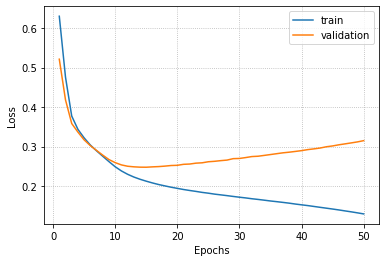

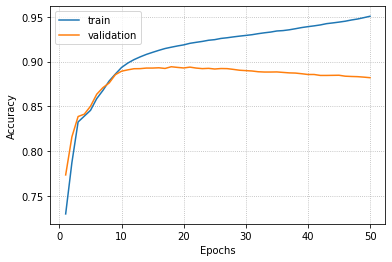

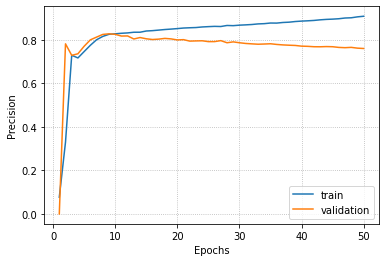

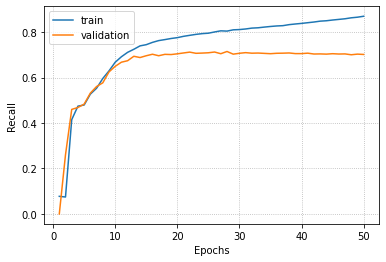

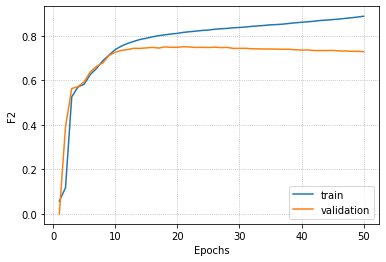

In [18]:
plt.close('all')
_, ax1 = plt.subplots()
ax1 = plot_results(ax1, train_losses, val_losses, 'Loss')
_, ax2 = plt.subplots()
ax2 = plot_results(ax2, train_metrics.accuracy, val_metrics.accuracy, 'Accuracy')
_, ax3 = plt.subplots()
ax3 = plot_results(ax3, train_metrics.precision, val_metrics.precision, 'Precision')
_, ax4 = plt.subplots()
ax4 = plot_results(ax4, train_metrics.recall, val_metrics.recall, 'Recall')
_, ax5 = plt.subplots()
ax5 = plot_results(ax5, train_metrics.F2, val_metrics.F2, 'F2')
plt.show()

In [19]:
vectorizer = TfidfVectorizer(max_features=2048, encoding='ascii')
X = vectorizer.fit_transform(top100['abstract'])
y = np.array([list(map(int, mask)) for mask in top100['keywords']],
             dtype='uint8')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

X_train.shape

(48331, 2048)

In [20]:
clf = MultiLabelClassifier(
    num_labels=100,
    binary_classifier=LinearSVC,
    kwargs={}
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

calculate_metrics(pred, y_test)

Metrics(accuracy=0.9746955874138894, precision=0.6734867860187553, recall=0.25278382183540254, F2=0.3675957377506864)

In [21]:
BATCH_SIZE = 2048
HIDDEN_IN = 1024
HIDDEN_OUT = 512
EPOCHS = 100
LEARNING_RATE = 5e-4

train_dataset = AbstractsDataset(X_train, y_train, BATCH_SIZE)
test_dataset = AbstractsDataset(X_test, y_test, BATCH_SIZE)

# choose device and initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(
    num_features=X.shape[1],
    num_labels=y.shape[1],
    shape_hidden=(HIDDEN_IN, HIDDEN_OUT)
)
model = model.to(device)

# train model
train_losses, val_losses, train_metrics, val_metrics = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    device=device,
    epochs=EPOCHS,
    lr=LEARNING_RATE
)

Epoch 1
Train: loss = 0.182, acc = 0.961, prec = 0.001, rec = 0.009, F2 = 0.002
Validation: loss = 0.128, acc = 0.971, prec = 0.000, rec = 0.000, F2 = 0.000

Epoch 2
Train: loss = 0.116, acc = 0.971, prec = 0.393, rec = 0.009, F2 = 0.017
Validation: loss = 0.106, acc = 0.971, prec = 0.547, rec = 0.015, F2 = 0.030

Epoch 3
Train: loss = 0.104, acc = 0.971, prec = 0.607, rec = 0.020, F2 = 0.039
Validation: loss = 0.101, acc = 0.971, prec = 0.600, rec = 0.026, F2 = 0.049

Epoch 4
Train: loss = 0.099, acc = 0.971, prec = 0.633, rec = 0.031, F2 = 0.058
Validation: loss = 0.097, acc = 0.971, prec = 0.652, rec = 0.035, F2 = 0.066

Epoch 5
Train: loss = 0.094, acc = 0.971, prec = 0.676, rec = 0.054, F2 = 0.100
Validation: loss = 0.092, acc = 0.972, prec = 0.674, rec = 0.074, F2 = 0.133

Epoch 6
Train: loss = 0.090, acc = 0.972, prec = 0.705, rec = 0.095, F2 = 0.167
Validation: loss = 0.089, acc = 0.973, prec = 0.671, rec = 0.118, F2 = 0.200

Epoch 7
Train: loss = 0.086, acc = 0.973, prec = 0.7

Train: loss = 0.006, acc = 1.000, prec = 0.998, rec = 0.990, F2 = 0.994
Validation: loss = 0.163, acc = 0.970, prec = 0.490, rec = 0.344, F2 = 0.404

Epoch 54
Train: loss = 0.005, acc = 1.000, prec = 0.998, rec = 0.994, F2 = 0.996
Validation: loss = 0.167, acc = 0.970, prec = 0.482, rec = 0.351, F2 = 0.406

Epoch 55
Train: loss = 0.004, acc = 1.000, prec = 0.999, rec = 0.996, F2 = 0.997
Validation: loss = 0.172, acc = 0.970, prec = 0.483, rec = 0.348, F2 = 0.405

Epoch 56
Train: loss = 0.004, acc = 1.000, prec = 0.999, rec = 0.997, F2 = 0.998
Validation: loss = 0.176, acc = 0.970, prec = 0.479, rec = 0.352, F2 = 0.405

Epoch 57
Train: loss = 0.003, acc = 1.000, prec = 0.999, rec = 0.998, F2 = 0.999
Validation: loss = 0.182, acc = 0.970, prec = 0.480, rec = 0.349, F2 = 0.404

Epoch 58
Train: loss = 0.003, acc = 1.000, prec = 0.999, rec = 0.999, F2 = 0.999
Validation: loss = 0.187, acc = 0.970, prec = 0.483, rec = 0.354, F2 = 0.408

Epoch 59
Train: loss = 0.002, acc = 1.000, prec = 0.999

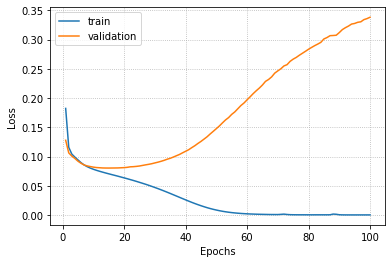

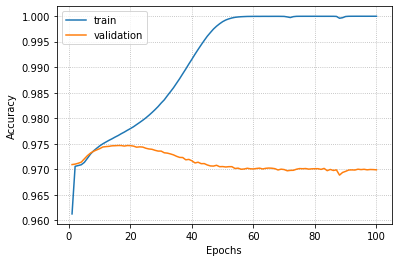

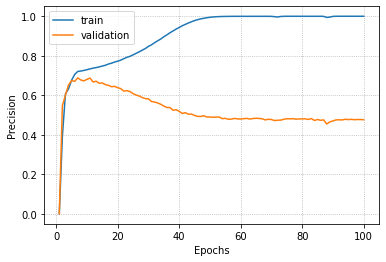

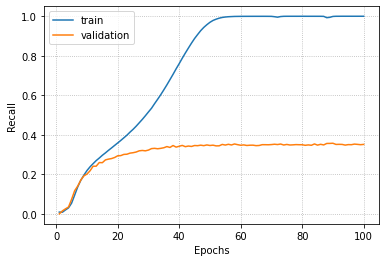

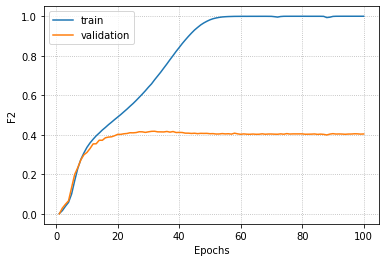

In [22]:
plt.close('all')
_, ax1 = plt.subplots()
ax1 = plot_results(ax1, train_losses, val_losses, 'Loss')
_, ax2 = plt.subplots()
ax2 = plot_results(ax2, train_metrics.accuracy, val_metrics.accuracy, 'Accuracy')
_, ax3 = plt.subplots()
ax3 = plot_results(ax3, train_metrics.precision, val_metrics.precision, 'Precision')
_, ax4 = plt.subplots()
ax4 = plot_results(ax4, train_metrics.recall, val_metrics.recall, 'Recall')
_, ax5 = plt.subplots()
ax5 = plot_results(ax5, train_metrics.F2, val_metrics.F2, 'F2')
plt.show()